In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig, TFDistilBertModel

C:\Users\saray\anaconda3\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\saray\anaconda3\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [3]:
data_file='New Data.csv'
data=pd.read_csv(data_file,encoding='ISO-8859-1')

data.head()

,Id,Judgment,Judgment Status
0,1,appeal judgment decree bombay high court stone...,1
1,2,application article 32 1 constitution enforcem...,2
2,3,appeal judgment high court hyderabad article 3...,0
3,4,appeal article 3744 constitution judgment decr...,0
4,5,petitions art 136 constitution praying special...,3


In [5]:
data=data.rename(columns = {'Judgment Status': 'label', 'Judgment': 'text'}, inplace = False)

print('Available labels: ',data.label.unique())

num_classes=len(data.label.unique())

data.head()

Available labels:  [1 2 0 3]


,Id,text,label
0,1,appeal judgment decree bombay high court stone...,1
1,2,application article 32 1 constitution enforcem...,2
2,3,appeal judgment high court hyderabad article 3...,0
3,4,appeal article 3744 constitution judgment decr...,0
4,5,petitions art 136 constitution praying special...,3


In [6]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

loading file vocab.txt from cache at C:\Users\saray/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\saray/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\saray/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,


In [7]:
max_len=100
sentences=data['text']
labels=data['label']
len(sentences),len(labels)

(320, 320)

In [8]:
dbert_tokenizer.tokenize(sentences[0])

['appeal',
 'judgment',
 'decree',
 'bombay',
 'high',
 'court',
 'stone',
 'c',
 '##j',
 'co',
 '##ya',
 '##jee',
 'j',
 'dated',
 '20th',
 'march',
 '1947',
 'appeal',
 '42',
 '1946',
 'rev',
 '##ers',
 '##ing',
 'judgment',
 'cha',
 '##gl',
 '##a',
 'j',
 'dismissing',
 'application',
 'made',
 'respond',
 'en',
 '##t',
 'indian',
 'arbitration',
 'act',
 '1940',
 'praying',
 'inter',
 'ali',
 '##a',
 'arbitration',
 'agreement',
 'contained',
 'certain',
 'contract',
 'notes',
 'sent',
 'app',
 '##ellant',
 '##s',
 'respond',
 '##ent',
 'declared',
 'invalid',
 'void',
 'setting',
 'aside',
 'award',
 'made',
 'ar',
 '##bit',
 '##rator',
 '##s',
 'appointed',
 'said',
 'contract',
 'note',
 'mc',
 'set',
 '##al',
 '##va',
 '##d',
 'ram',
 '##esh',
 '##war',
 'nat',
 '##h',
 'app',
 '##el',
 'lan',
 '##ts',
 'ck',
 'da',
 '##ph',
 '##tary',
 'b',
 'sen',
 'k',
 '##t',
 'des',
 '##ai',
 'respond',
 '##ent',
 '1950',
 'march',
 '14',
 'judgment',
 'court',
 'delivered',
 'das',
 'j',


In [9]:
dbert_inp=dbert_tokenizer.encode_plus(sentences[0],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)
dbert_inp

C:\Users\saray\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [101, 5574, 8689, 10037, 11831, 2152, 2457, 2962, 1039, 3501, 2522, 3148, 16963, 1046, 6052, 3983, 2233, 4006, 5574, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
dbert_inp['input_ids']

[101,
 5574,
 8689,
 10037,
 11831,
 2152,
 2457,
 2962,
 1039,
 3501,
 2522,
 3148,
 16963,
 1046,
 6052,
 3983,
 2233,
 4006,
 5574,
 102]

In [11]:
id_inp=np.asarray(dbert_inp['input_ids'])
mask_inp=np.asarray(dbert_inp['attention_mask'])
out=dbert_model([id_inp.reshape(1,-1),mask_inp.reshape(1,-1)])
type(out),out

(transformers.modeling_tf_outputs.TFBaseModelOutput,
 TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
 array([[[-0.05656294, -0.13237165, -0.6848408 , ..., -0.13577443,
           0.08755861,  0.2803257 ],
         [ 0.12282754, -0.2580493 , -0.30668104, ...,  0.01460887,
           0.5224225 , -0.16475444],
         [-0.20098601, -0.24642448, -0.30848378, ..., -0.4634495 ,
           0.10584606, -0.0470039 ],
         ...,
         [-0.11351083, -0.17789598, -0.38391262, ..., -0.36827943,
           0.10353646, -0.03700799],
         [ 0.07343004, -0.19586274, -0.2366223 , ..., -0.21823832,
          -0.19672078, -0.27242097],
         [ 0.95784324, -0.10809351, -0.35566974, ...,  0.2982176 ,
          -0.4224195 , -0.47203332]]], dtype=float32)>, hidden_states=None, attentions=None))

In [12]:
dbert_tokenizer.decode(dbert_inp['input_ids'])

'[CLS] appeal judgment decree bombay high court stone cj coyajee j dated 20th march 1947 appeal [SEP]'

In [13]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model  

In [14]:
model=create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 100, 768),                                                   
                                 hidden_states=None                                           

In [15]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

(320, 320, 320)

In [18]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.25)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (240, 100) Val input shape (80, 100)
Train label shape (240,) Val label shape (80,)
Train attention mask shape (240, 100) Val attention mask shape (80, 100)


In [20]:
history=model.fit([train_inp,train_mask],train_label,batch_size = 32,epochs = 10,validation_data=([val_inp,val_mask],val_label))

Epoch 1/10
8/8 [==============================] - 44s 5s/step - loss: 6.8303 - accuracy: 0.6125 - val_loss: 7.1822 - val_accuracy: 0.3750
Epoch 2/10
8/8 [==============================] - 44s 6s/step - loss: 6.7021 - accuracy: 0.6125 - val_loss: 7.1023 - val_accuracy: 0.4625
Epoch 3/10
8/8 [==============================] - 43s 5s/step - loss: 6.5430 - accuracy: 0.6833 - val_loss: 7.1868 - val_accuracy: 0.4875
Epoch 4/10
8/8 [==============================] - 47s 6s/step - loss: 6.3827 - accuracy: 0.7750 - val_loss: 7.2392 - val_accuracy: 0.4750
Epoch 5/10
8/8 [==============================] - 45s 6s/step - loss: 6.2480 - accuracy: 0.8500 - val_loss: 7.3185 - val_accuracy: 0.4875
Epoch 6/10
8/8 [==============================] - 44s 6s/step - loss: 6.1286 - accuracy: 0.9000 - val_loss: 7.4562 - val_accuracy: 0.4625
Epoch 7/10
8/8 [==============================] - 43s 5s/step - loss: 6.0146 - accuracy: 0.9125 - val_loss: 7.7468 - val_accuracy: 0.4625
Epoch 8/10
8/8 [==================

In [24]:
preds = model.predict([val_inp,val_mask],batch_size=16)

5/5 [==============================] - 5s 838ms/step


In [31]:
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels,average='weighted')
f1

0.48669642857142853

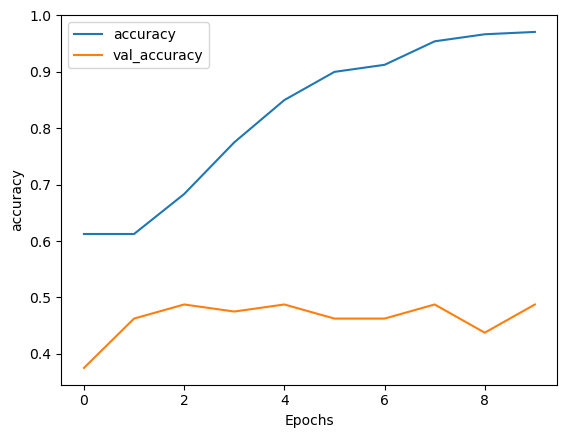

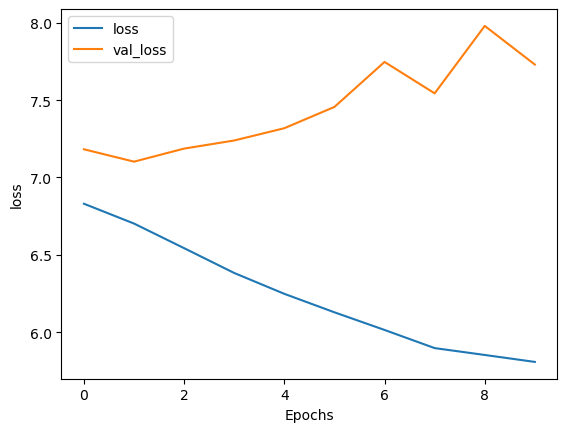

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")